# 프로젝트 배경 및 목적
- 프로젝트 목적: 연체에 영향을 미치는 주요 요인을 파악하고, 신용 등급 분류 모델을 통해 어떤 특징 때문에 특정 신용 등급이 할당되었는지 파악하고 해당 분석을 통해 신용 등급을 향상시킬 수 있는 액션 플랜을 제안합니다.

### 1. 신용 등급 분류의 의미와 기준 파악
- 문제 정의: 신용 등급을 0, 1, 2로 분류했을 때, 각 등급이 나타내는 구체적인 의미와 기준은 무엇인가? 이러한 분류 기준이 실제 금융 환경에서 어떤 영향을 미치는가?
- 해결 방안: 신용 등급을 결정하는 요인들을 분석하고, 각 등급별로 구분되는 특징들을 파악하여, 신용 등급과 금융 건전성 사이의 관계를 설명할 수 있는 모델을 개발합니다.
### 2. 연체에 영향을 주는 요인 분석
- 문제 정의: 어떤 변수들이 신용 연체에 가장 큰 영향을 주는가? 이러한 요인들을 통제하거나 개선함으로써 연체율을 감소시킬 수 있는 방법은 무엇인가?
- 해결 방안: 샤플리 값(Shapley Value)을 활용하여 각 변수의 중요도를 평가하고, 주요 요인들에 대한 대책을 마련합니다.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train=pd.read_csv('/content/drive/MyDrive/train.csv')
test=pd.read_csv('/content/drive/MyDrive/test.csv')

In [5]:
train.shape

(26457, 20)

In [6]:
test.shape

(10000, 19)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [8]:
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [9]:
train=train.drop('occyp_type', axis=1)
test=test.drop('occyp_type', axis=1)

In [10]:
unique_len = train.apply(lambda x : len(x.unique()))

unique_len

index            26457
gender               2
car                  2
reality              2
child_num            9
income_total       249
income_type          5
edu_type             5
family_type          5
house_type           6
DAYS_BIRTH        6621
DAYS_EMPLOYED     3470
FLAG_MOBIL           1
work_phone           2
phone                2
email                2
family_size         10
begin_month         61
credit               3
dtype: int64

In [11]:
train=train.drop('index', axis=1)
test=test.drop('index', axis=1)

train=train.drop('FLAG_MOBIL', axis=1)
test=test.drop('FLAG_MOBIL', axis=1)

In [12]:
train['gender'] = train['gender'].replace(['F','M'],[0,1])
test['gender'] = test['gender'].replace(['F','M'],[0,1])
print(train['gender'].value_counts())

train['car'] = train['car'].replace(['N','Y'],[0,1])
test['car'] = test['car'].replace(['N','Y'],[0,1])
print(train['car'].value_counts())

train['reality'] = train['reality'].replace(['N','Y'],[0,1])
test['reality'] = test['reality'].replace(['N','Y'],[0,1])
print(train['reality'].value_counts())

print(train['phone'].value_counts())

print(train['email'].value_counts())

print(train['work_phone'].value_counts())

gender
0    17697
1     8760
Name: count, dtype: int64
car
0    16410
1    10047
Name: count, dtype: int64
reality
1    17830
0     8627
Name: count, dtype: int64
phone
0    18672
1     7785
Name: count, dtype: int64
email
0    24042
1     2415
Name: count, dtype: int64
work_phone
0    20511
1     5946
Name: count, dtype: int64


In [13]:
train=train.drop('child_num', axis=1)
test=test.drop('child_num', axis=1)
print(train['family_size'].value_counts())

family_size
2.0     14106
1.0      5109
3.0      4632
4.0      2260
5.0       291
6.0        44
7.0         9
15.0        3
9.0         2
20.0        1
Name: count, dtype: int64


In [14]:
quartiles = train['family_size'].quantile([0.25, 0.5, 0.75])
print(quartiles)

0.25    2.0
0.50    2.0
0.75    3.0
Name: family_size, dtype: float64


In [15]:
train.loc[train['family_size'] >= 4,'family_size']=4
test.loc[test['family_size']>=4, 'family_size']=4
print(train['family_size'].value_counts())

family_size
2.0    14106
1.0     5109
3.0     4632
4.0     2610
Name: count, dtype: int64


In [16]:
def days_to_year(x):
    if x<0:
        return (x*(-1))/365
    return 0

def minus_to_plus(x):
    if x<0:
        return x*(-1)
    return 0

In [17]:
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].apply(days_to_year)
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(days_to_year)
train['begin_month'] = train['begin_month'].apply(minus_to_plus)

test['DAYS_BIRTH'] = test['DAYS_BIRTH'].apply(days_to_year)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].apply(days_to_year)
test['begin_month'] = test['begin_month'].apply(minus_to_plus)

In [18]:
#생략 가능

train['family_size'] = train['family_size'].astype('int64')
test['family_size'] = test['family_size'].astype('int64')

train['begin_month'] = train['begin_month'].astype('int64')
test['begin_month'] = test['begin_month'].astype('int64')

# 여기까지 기본 전처리

# 라벨 인코딩일 경우

In [19]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

train['income_type'] = label_encoder.fit_transform(train['income_type'])
test['income_type'] = label_encoder.transform(test['income_type'])

#교육 수준 순서 고려
edu_type_mapping = {
    'Lower secondary': 0,
    'Secondary / secondary special': 1,
    'Incomplete higher': 2,
    'Higher education': 3,
    'Academic degree': 4
}
train['edu_type'] = train['edu_type'].map(edu_type_mapping)
test['edu_type'] = test['edu_type'].map(edu_type_mapping)

train['family_type'] = label_encoder.fit_transform(train['family_type'])
test['family_type'] = label_encoder.transform(test['family_type'])

train['house_type'] = label_encoder.fit_transform(train['house_type'])
test['house_type'] = label_encoder.transform(test['house_type'])

In [20]:
train.head()

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit
0,0,0,0,202500.0,0,3,1,2,38.079452,12.901370,0,0,0,2,6,1.0
1,0,0,1,247500.0,0,1,0,1,31.178082,4.219178,0,0,1,3,5,1.0
2,1,1,1,450000.0,4,3,1,1,52.293151,12.147945,0,1,0,2,22,2.0
3,0,0,1,202500.0,0,1,1,1,41.336986,5.731507,0,1,0,2,37,0.0
4,0,1,1,157500.0,2,3,1,1,41.197260,5.767123,0,0,0,2,26,2.0


# 원핫 인코딩일 경우(두번 인코딩하지 않게 주의)

In [21]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

encoder = OneHotEncoder(sparse_output=False)

income_type_encoded = encoder.fit_transform(train[['income_type']])
income_type_encoded_df = pd.DataFrame(income_type_encoded, columns=encoder.get_feature_names_out(['income_type']))
train = pd.concat([train, income_type_encoded_df], axis=1).drop('income_type', axis=1)

income_type_encoded_test = encoder.transform(test[['income_type']])
income_type_encoded_test_df = pd.DataFrame(income_type_encoded_test, columns=encoder.get_feature_names_out(['income_type']))
test = pd.concat([test, income_type_encoded_test_df], axis=1).drop('income_type', axis=1)

encoder = OneHotEncoder(sparse_output=False)
edu_type_encoded = encoder.fit_transform(train[['edu_type']])
edu_type_encoded_df = pd.DataFrame(edu_type_encoded, columns=encoder.get_feature_names_out(['edu_type']))
train = pd.concat([train, edu_type_encoded_df], axis=1).drop('edu_type', axis=1)

edu_type_encoded_test = encoder.transform(test[['edu_type']])
edu_type_encoded_test_df = pd.DataFrame(edu_type_encoded_test, columns=encoder.get_feature_names_out(['edu_type']))
test = pd.concat([test, edu_type_encoded_test_df], axis=1).drop('edu_type', axis=1)

encoder = OneHotEncoder(sparse_output=False)
family_type_encoded = encoder.fit_transform(train[['family_type']])
family_type_encoded_df = pd.DataFrame(family_type_encoded, columns=encoder.get_feature_names_out(['family_type']))
train = pd.concat([train, family_type_encoded_df], axis=1).drop('family_type', axis=1)

family_type_encoded_test = encoder.transform(test[['family_type']])
family_type_encoded_test_df = pd.DataFrame(family_type_encoded_test, columns=encoder.get_feature_names_out(['family_type']))
test = pd.concat([test, family_type_encoded_test_df], axis=1).drop('family_type', axis=1)

encoder = OneHotEncoder(sparse_output=False)
house_type_encoded = encoder.fit_transform(train[['house_type']])
house_type_encoded_df = pd.DataFrame(house_type_encoded, columns=encoder.get_feature_names_out(['house_type']))
train = pd.concat([train, house_type_encoded_df], axis=1).drop('house_type', axis=1)

house_type_encoded_test = encoder.transform(test[['house_type']])
house_type_encoded_test_df = pd.DataFrame(house_type_encoded_test, columns=encoder.get_feature_names_out(['house_type']))
test = pd.concat([test, house_type_encoded_test_df], axis=1).drop('house_type', axis=1)

In [22]:
train.head()

,gender,car,reality,income_total,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,...,family_type_1,family_type_2,family_type_3,family_type_4,house_type_0,house_type_1,house_type_2,house_type_3,house_type_4,house_type_5
0,0,0,0,202500.0,38.079452,12.901370,0,0,0,2,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,0,1,247500.0,31.178082,4.219178,0,0,1,3,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,1,1,450000.0,52.293151,12.147945,0,1,0,2,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0,0,1,202500.0,41.336986,5.731507,0,1,0,2,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,1,1,157500.0,41.197260,5.767123,0,0,0,2,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#EDA

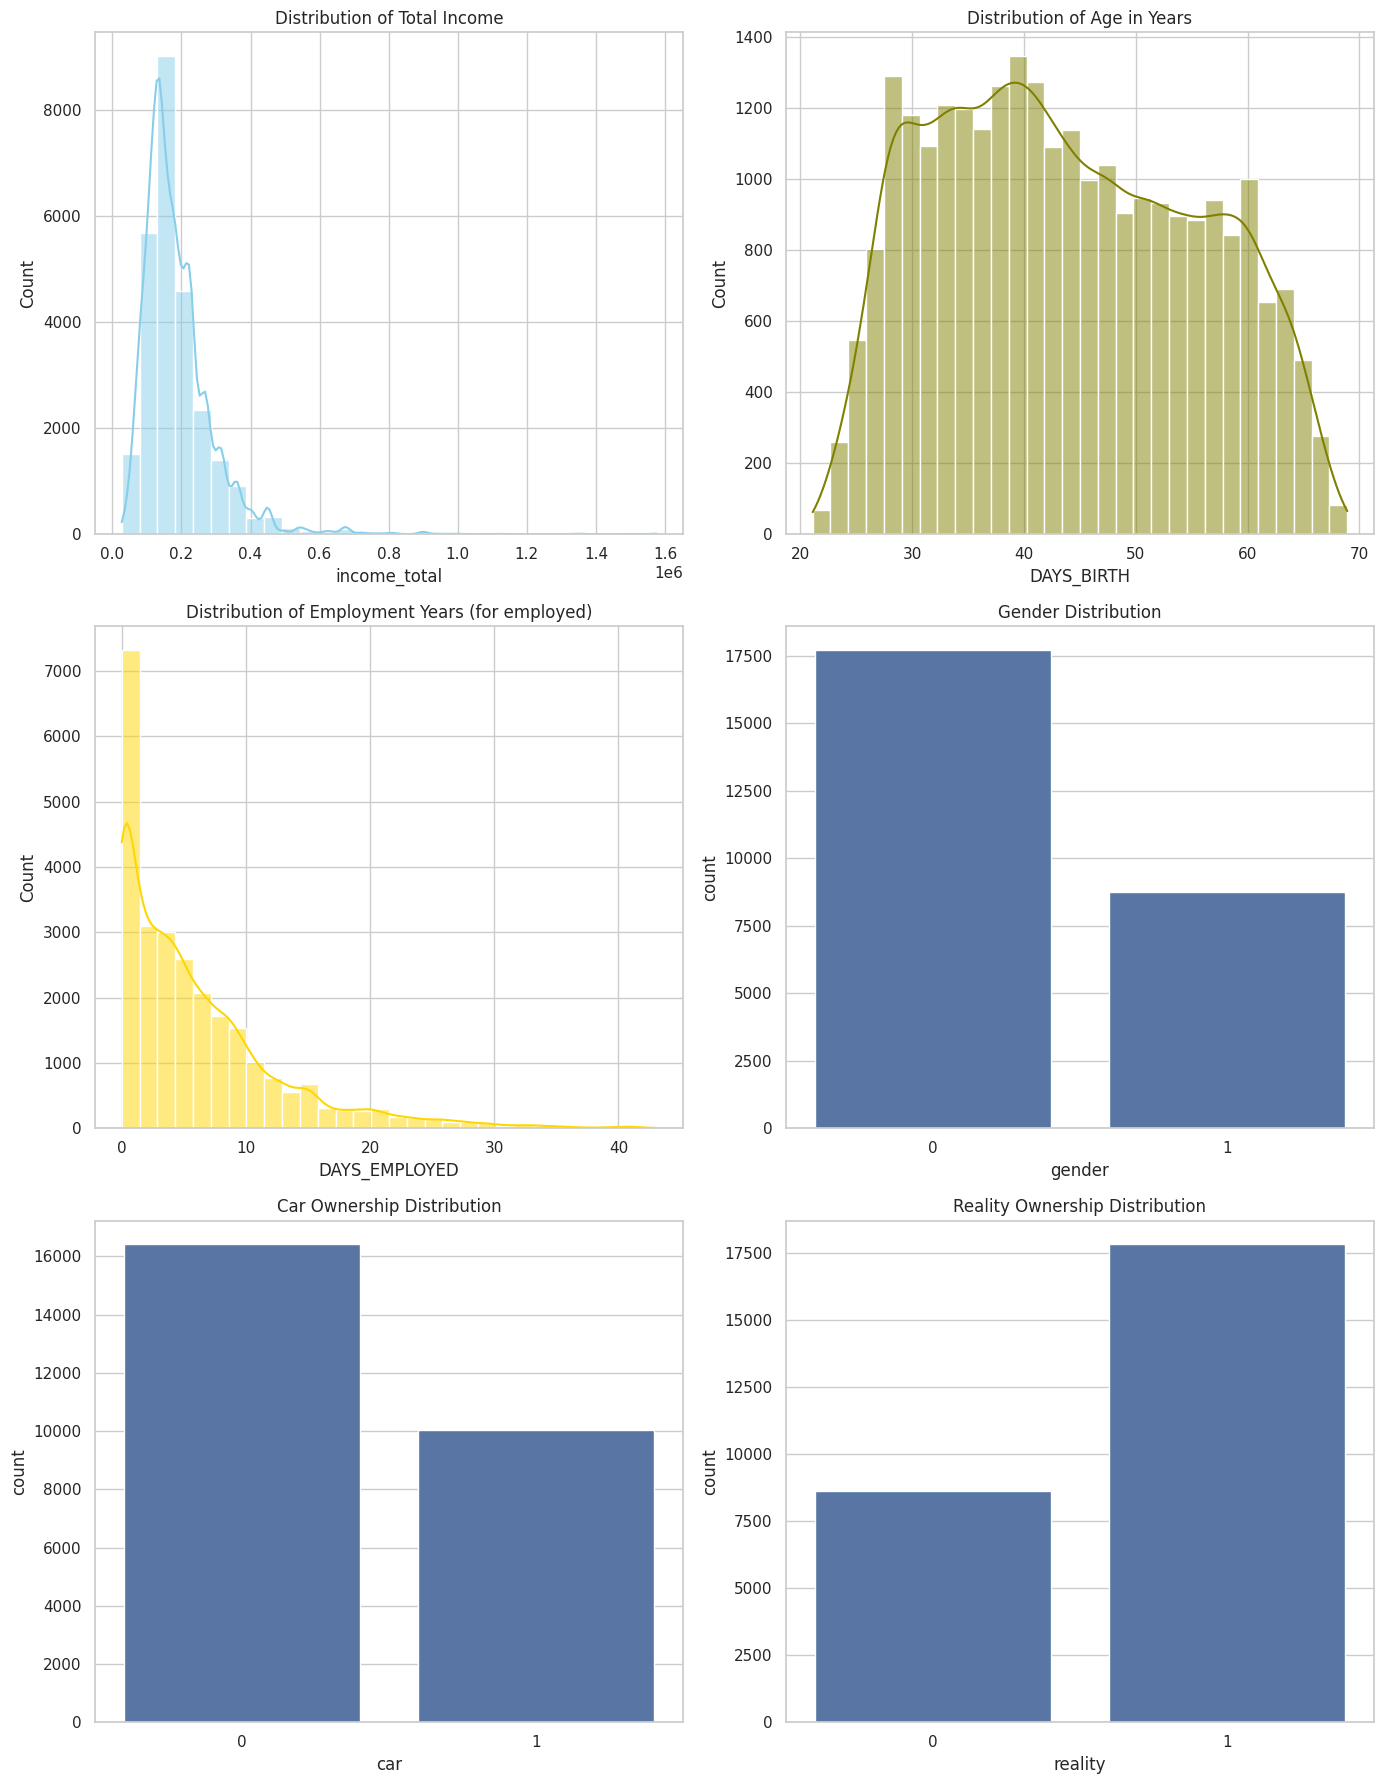

In [23]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 18))

#총 수입 분포: 대부분의 고객이 연간 약 100,000에서 300,000 사이의 수입
# 수입 분포는 오른쪽으로 긴 꼬리를 가지고 있어, 높은 수입을 보고하는 소수의 고객 존재
sns.histplot(train['income_total'], bins=30, ax=axes[0, 0], kde=True, color='skyblue')
axes[0, 0].set_title('Distribution of Total Income')

# 나이 분포: 고객의 나이는 대략 20세에서 68세 사이에 분포
# 특히 30대와 40대 초반에 많은 고객이 존재
sns.histplot(train['DAYS_BIRTH'], bins=30, ax=axes[0, 1], kde=True, color='olive')
axes[0, 1].set_title('Distribution of Age in Years')

# 고용 연수 분포: 고용된 사람들의 고용 연수는 대부분 0년에서 20년 사이
# 일부 고객은 40년 이상 고용 상태에 있기도 합니다.
sns.histplot(train['DAYS_EMPLOYED'], bins=30, ax=axes[1, 0], kde=True, color='gold')
axes[1, 0].set_title('Distribution of Employment Years (for employed)')

# 성별 분포: 남성(1)보다 여성(0) 고객의 수가 더 많습니다.
sns.countplot(x='gender', data=train, ax=axes[1, 1])
axes[1, 1].set_title('Gender Distribution')

# 차량 소유 분포: 차량을 소유하지 않은 고객이 소유한 고객보다 약간 많습니다.
sns.countplot(x='car', data=train, ax=axes[2, 0])
axes[2, 0].set_title('Car Ownership Distribution')

# 부동산 소유 분포: 대다수의 고객이 부동산을 소유하고 있습니다.
sns.countplot(x='reality', data=train, ax=axes[2, 1])
axes[2, 1].set_title('Reality Ownership Distribution')

plt.tight_layout()
plt.show()

# SVM

In [24]:
# 특성과 타겟 분리
X = train.drop('credit', axis=1)
y = train['credit']

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# SVM 모델 초기화 및 훈련 (RBF 커널)
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

# 예측 및 성능 평가
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# 결과 출력
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.6436130007558579
Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.01      0.02       650
         1.0       0.59      0.03      0.06      1262
         2.0       0.64      0.99      0.78      3380

    accuracy                           0.64      5292
   macro avg       0.65      0.34      0.29      5292
weighted avg       0.64      0.64      0.52      5292



In [25]:
!pip install imbalanced-learn

In [26]:
from imblearn.under_sampling import RandomUnderSampler

# 언더샘플링 적용
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# SVM 모델 초기화 및 훈련 (RBF 커널)
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_resampled, y_resampled)

# 예측 및 성능 평가
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# 결과 출력
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.4595616024187453
Classification Report:
              precision    recall  f1-score   support

         0.0       0.17      0.38      0.23       650
         1.0       0.36      0.43      0.39      1262
         2.0       0.72      0.49      0.58      3380

    accuracy                           0.46      5292
   macro avg       0.41      0.43      0.40      5292
weighted avg       0.56      0.46      0.49      5292



In [ ]:
from sklearn.metrics import log_loss, accuracy_score, classification_report
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# SVM 모델 훈련 (확률 추정을 위해 CalibratedClassifierCV 사용)
svm = SVC(kernel='rbf', probability=True, random_state=42)
calibrated_svm = CalibratedClassifierCV(svm, method='sigmoid', cv=5)
calibrated_svm.fit(X_train_smote, y_train_smote)

# 예측 및 확률 추정
y_pred = calibrated_svm.predict(X_test)
y_proba = calibrated_svm.predict_proba(X_test)

# 성능 평가
accuracy = accuracy_score(y_test, y_pred)
log_loss_val = log_loss(y_test, y_proba)
report = classification_report(y_test, y_pred)

# 결과 출력
print(f"Accuracy: {accuracy}")
print(f"Log Loss: {log_loss_val}")
print("Classification Report:")
print(report)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


# 훈련 데이터와 테스트 데이터 분리
X = train.drop('credit', axis=1)
y = train['credit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# SVM 모델 초기화 및 훈련 - 선형 커널
svm_linear = SVC(kernel='linear', random_state=100)
svm_linear.fit(X_train, y_train)

# 예측 및 정확도 평가
y_pred_linear = svm_linear.predict(X_test)
accuracy_linear = accuracy_score(y_test, y_pred_linear)
cross_val_scores_linear = cross_val_score(svm_linear, X, y, cv=5)

# SVM 모델 초기화 및 훈련 - RBF 커널
svm_rbf = SVC(kernel='rbf', random_state=100)
svm_rbf.fit(X_train, y_train)

# 예측 및 정확도 평가
y_pred_rbf = svm_rbf.predict(X_test)
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
cross_val_scores_rbf = cross_val_score(svm_rbf, X, y, cv=5)

# 하이퍼파라미터 튜닝 - GridSearchCV
parameters = {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1]}
grid_search = GridSearchCV(svm_rbf, parameters, cv=5)
grid_search.fit(X_train, y_train)

# 최적의 파라미터와 함께 훈련된 모델의 점수
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Linear Model Accuracy: {accuracy_linear}, Cross-validation Score: {cross_val_scores_linear.mean()}")
print(f"RBF Model Accuracy: {accuracy_rbf}, Cross-validation Score: {cross_val_scores_rbf.mean()}")
print(f"Best Parameters: {best_params}, Best Cross-validation Score: {best_score}")


##Shapley value
머신러닝에서는 모델 예측에 각 피처가 얼마나 중요한 역할을 하는지를 정량화하는 데 사용됩니다. 이 값은 각 피처가 결과에 미치는 기여도를 나타내며, 피처의 중요도를 이해하는 데 매우 유용합니다.

Shapley Value를 사용한 모델 설명
Shapley Value는 모델의 예측에 대한 각 피처의 기여도를 평가하여, 모델의 작동 방식을 투명하게 만듭니다. 예를 들어, 신용 점수 예측 모델에서 어떤 피처가 신용 점수에 부정적 혹은 긍정적으로 영향을 미치는지 파악할 수 있습니다. 이 정보는 다음과 같은 통찰력을 제공할 수 있습니다:

- 중요 피처 식별: 모델 예측에 가장 큰 영향을 미치는 피처들을 식별합니다.
- 정책 결정 지원: 중요 피처들에 대한 인사이트를 바탕으로 효과적인 정책 결정을 도울 수 있습니다.
- 데이터 수집 전략 개선: 중요도가 낮은 피처를 확인하고, 불필요한 데이터 수집을 줄일 수 있습니다.

In [ ]:
!pip install shap

In [ ]:
import shap
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

X = train.drop('credit', axis=1)
y = train['credit']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM 모델과 파이프라인 생성
model = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))
model.fit(X_train, y_train)

# SHAP 값 계산
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_test)

# SHAP 요약 플롯
shap.summary_plot(shap_values, X_test, plot_type="bar")


PermutationExplainer explainer:  29%|██▉       | 1537/5292 [3:57:32<8:36:00,  8.25s/it]

In [ ]:
credit_distribution = train['credit'].value_counts(normalize=True)

#신용 등급별 통계 요약
stat_by_credit = train.groupby('credit').agg(['mean', 'std', 'min', 'max'])

credit_distribution, stat_by_credit

In [ ]:
correlation_matrix = train.corr()
credit_corr = correlation_matrix['credit'].sort_values()

#신용등급별 상관분석
plt.figure(figsize=(12, 8))
sns.barplot(x=credit_corr.index, y=credit_corr.values)
plt.title('Correlation of Variables with Credit Rating')
plt.xticks(rotation=90, ha='right')
plt.ylabel('Correlation Coefficient')
plt.show()

credit_corr